#**NOTEBOOK IMPORTS**

In [18]:
import tensorflow as tf
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tensorflow.keras.applications.vgg19 import VGG19
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras import Model
from keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix

#**LOAD DATA**

In [19]:
path = '/content/drive/MyDrive/Data'
os.listdir(path)

['training', 'validation']

In [20]:
# Load the VGG19 model without the top (fully connected) layers
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

# Freeze the base model's layers
for layer in base_model.layers:
    layer.trainable = False

In [21]:
TRAINING_DIR = '/content/drive/MyDrive/Data/training'
VALIDATION_DIR = '/content/drive/MyDrive/Data/validation'

In [22]:
base_model.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

In [25]:
# Choose `mixed_7` as the last layer of your base model
last_layer = base_model.get_layer('block5_conv2')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 16, 16, 512)


In [26]:
# Add your own custom top layers
x = layers.Flatten()(last_output)
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)
# Add a final sigmoid layer for classification
x = layers.Dense(4, activation='softmax')(x)

# Append the dense network to the base model
model = Model(base_model.input, x)

# Print the model summary. See your dense network connected at the end.
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0   

In [27]:
# Set the training parameters
model.compile(optimizer = 'adam',
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

In [28]:
%%time

training_datagen = ImageDataGenerator(
    rescale = 1./255)
    # rotation_range=40,
    # width_shift_range=0.2,
    # height_shift_range=0.2,
    # shear_range=0.2,
    # zoom_range=0.2,
    # horizontal_flip=True,
    # fill_mode='nearest')

train_generator = training_datagen.flow_from_directory(
    TRAINING_DIR,
    target_size=(256,256),
    class_mode='categorical',
    batch_size=128
)


validation_datagen = ImageDataGenerator(rescale = 1./255)

validation_generator = validation_datagen.flow_from_directory(
    VALIDATION_DIR,
    target_size=(256,256),
    class_mode='categorical',
    batch_size=30)

Found 4806 images belonging to 4 classes.
Found 1910 images belonging to 4 classes.
CPU times: user 196 ms, sys: 6.46 ms, total: 203 ms
Wall time: 420 ms


In [29]:
%%time

# Train the model.
history = model.fit(
            train_generator,
            validation_data = validation_generator,
            steps_per_epoch = 25,
            epochs = 10,
            validation_steps = 64,
            verbose = 1)
            #callbacks=[callbacks])

Epoch 1/10
25/25 [==============================] - 70s 2s/step - loss: 47.1910 - accuracy: 0.5387 - val_loss: 3.2703 - val_accuracy: 0.8120
Epoch 2/10
25/25 [==============================] - 49s 2s/step - loss: 2.2856 - accuracy: 0.8345 - val_loss: 0.7666 - val_accuracy: 0.9042
Epoch 3/10
25/25 [==============================] - 44s 2s/step - loss: 0.4774 - accuracy: 0.9290 - val_loss: 0.4582 - val_accuracy: 0.9136
Epoch 4/10
25/25 [==============================] - 37s 1s/step - loss: 0.1257 - accuracy: 0.9663 - val_loss: 0.2667 - val_accuracy: 0.9387
Epoch 5/10
25/25 [==============================] - 37s 1s/step - loss: 0.0637 - accuracy: 0.9803 - val_loss: 0.2329 - val_accuracy: 0.9414
Epoch 6/10
25/25 [==============================] - 44s 2s/step - loss: 0.0269 - accuracy: 0.9924 - val_loss: 0.2499 - val_accuracy: 0.9325
Epoch 7/10
25/25 [==============================] - 37s 1s/step - loss: 0.0206 - accuracy: 0.9924 - val_loss: 0.2722 - val_accuracy: 0.9356
Epoch 8/10
25/25 [=

# **VISUALIZE THE TRAINING/VALIDATION ACCURACY AND LOSS**

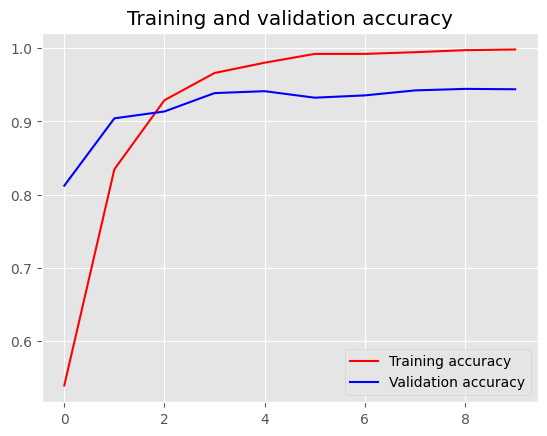

<Figure size 640x480 with 0 Axes>

In [30]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

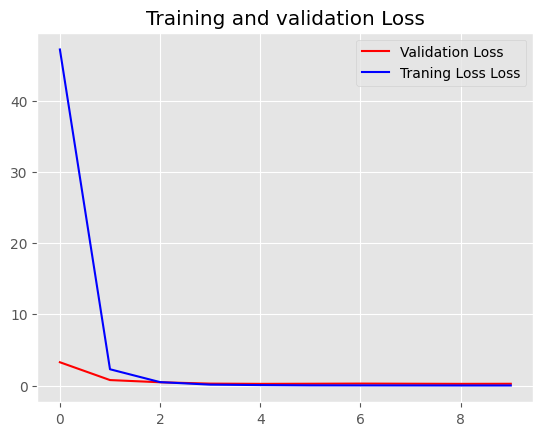

<Figure size 640x480 with 0 Axes>

In [31]:
plt.style.use('ggplot')

plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.plot(epochs, loss, 'b', label='Traning Loss Loss')
plt.title('Training and validation Loss')
plt.legend(loc=0)
plt.figure()


plt.show()

# **MODEL EVALUATION**

In [32]:
# Get predictions for the validation set
y_true = validation_generator.classes
y_pred_probs = model.predict(validation_generator)
y_pred = np.argmax(y_pred_probs, axis=1)

# Calculate the loss and accuracy
loss = history.history['loss'][-1]
accuracy = history.history['accuracy'][-1]

# Calculate the precision, recall, false positive, and false negative
conf_matrix = confusion_matrix(y_true, y_pred)
false_positive = conf_matrix.sum(axis=0) - np.diag(conf_matrix)
false_negative = conf_matrix.sum(axis=1) - np.diag(conf_matrix)

print("Loss:", loss)
print("Accuracy:", accuracy)
print("False Positive:", false_positive)
print("False Negative:", false_negative)
print("Confusion Matrix:")
print(conf_matrix)

64/64 [==============================] - 13s 207ms/step
Loss: 0.006964650005102158
Accuracy: 0.9984086751937866
False Positive: [406 244 368 377]
False Negative: [388 281 364 362]
Confusion Matrix:
[[167  91 149 148]
 [ 96  58  93  92]
 [142  85 137 137]
 [168  68 126 153]]


# **VISUALISE THE CONFUSION MATRIX**

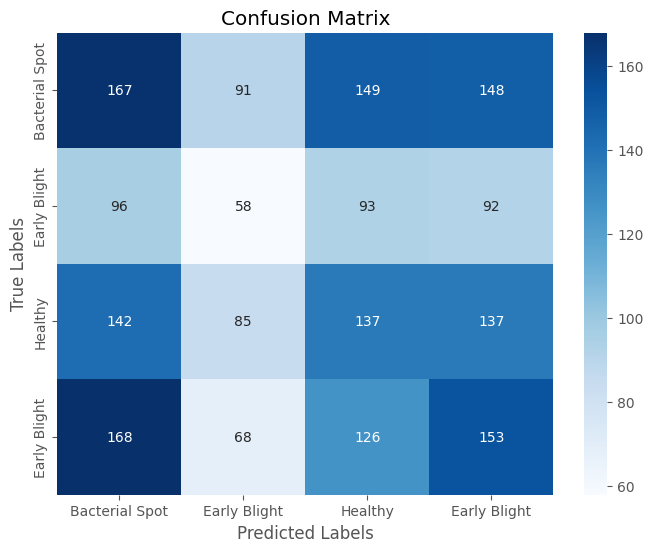

In [33]:
class_labels = ['Bacterial Spot', 'Early Blight', 'Healthy', 'Early Blight']

# Create the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)

# Add labels and title
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")

# Show the plot
plt.show()

#**SAVE MODEL**

In [ ]:
model.save('VGG19.h5')

from google.colab import files
files.download('/content/VGG19.h5')